In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import inf

In [47]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [25]:
colnames=['timestamp', 'game_name', 'num_channels', 'num_viewers']

In [173]:
df=pd.read_csv('Natasha.csv',header =None, names = colnames)

In [174]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [175]:
df=df.sort_values(by=['game_name','timestamp'])

In [176]:
df.reset_index(inplace = True)

In [177]:
df.drop(columns='index',inplace = True)

In [178]:
# df['diff_channels'] = df['num_channels']
# df['diff_viewers'] = df['num_viewers']
# for row_index in range(1,df.shape[0]):
#     # 0 - time_logged
#     # 1 - game_name
#     # 2 - num_channels
#     # 3 - num_viewers
#     # 4 - diff_channels
#     # 5 - diff_viewers
    
    
#     # Check if game_name of this row and previous row are the same
#     if df.iloc[row_index,1] == df.iloc[row_index-1,1]:
#         df.iloc[row_index,4] = int(df.iloc[row_index,2] - df.iloc[row_index-1,2])
#         df.iloc[row_index,5] = int(df.iloc[row_index,3] - df.iloc[row_index-1,3])
#     else:
#     # If the game names are different, the difference between metrics is invalid, fill with NaN
#         df.iloc[row_index,4] = np.NaN
#         df.iloc[row_index,5] = np.NaN

In [179]:
df['diff_channels'] = df['num_channels']
df['diff_viewers'] = df['num_viewers']

In [180]:
df_values =  df.values

In [181]:
df_values[4,1]

' F1 2019'

In [182]:
for row_index in range(1,df.shape[0]):
    # 0 - time_logged
    # 1 - game_name
    # 2 - num_channels
    # 3 - num_viewers
    # 4 - diff_channels
    # 5 - diff_viewers
    
    
    # Check if game_name of this row and previous row are the same
    if df_values[row_index,1] == df_values[row_index-1,1]:
        df_values[row_index,4] = int(df_values[row_index,2] - df_values[row_index-1,2])
        df_values[row_index,5] = int(df_values[row_index,3] - df_values[row_index-1,3])
    else:
    # If the game names are different, the difference between metrics is invalid, fill with NaN
        df_values[row_index,4] = np.NaN
        df_values[row_index,5] = np.NaN

In [188]:
test_df=pd.DataFrame(df_values).rename(columns={0: 'timestamp',
                                                1: 'game_name',
                                                2: 'num_channels',
                                                3: 'num_viewers',
                                                4: 'diff_channels',
                                                5: 'diff_viewers'})

In [189]:
index_n=50000
test_df.iloc[index_n:index_n+20]

,timestamp,game_name,num_channels,num_viewers,diff_channels,diff_viewers
50000,2019-05-28 15:00:00,Alone in the Dark,1,1,0,-1
50001,2019-05-28 16:00:00,Alone in the Dark,1,1,0,0
50002,2019-05-30 11:00:00,Alone in the Dark,1,0,0,-1
50003,2019-05-30 12:00:00,Alone in the Dark,1,3,0,3
50004,2019-05-30 13:00:00,Alone in the Dark,1,3,0,0
50005,2019-04-22 18:00:00,Alone in the Dark 2,1,1,NaN,NaN
50006,2019-04-22 19:00:00,Alone in the Dark 2,1,1,0,0
50007,2019-04-22 20:00:00,Alone in the Dark 2,1,1,0,0
50008,2019-04-22 21:00:00,Alone in the Dark 2,1,1,0,0
50009,2019-04-22 22:00:00,Alone in the Dark 2,1,1,0,0


In [ ]:
df

In [ ]:
df.loc

In [81]:
df.shape

(764750, 8)

In [77]:
df.shape

(6916512, 10)

In [65]:
df['game_name'].nunique()

360

In [64]:
764750/(40*24)

796.6145833333334

In [27]:
df.head()

,timestamp,game_name,num_channels,num_viewers
0,2019-04-22 00:00:00.000,League of Legends,3160,97898
1,2019-04-22 00:00:00.000,Counter-Strike: Global Offensive,1246,54330
2,2019-04-22 00:00:00.000,Ultra Street Fighter IV,2,144
3,2019-04-22 00:00:00.000,Hearthstone,224,33632
4,2019-04-22 00:00:00.000,Dota 2,467,27497


In [28]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [82]:
LoL = df.loc[df['game_name']== 'League of Legends']

In [89]:
LoL.head()

,game_name,date,hourly_channels,hourly_viewers,channel_change,viewership_change,channel_diff,viewers_diff
3204625,League of Legends,2019-04-22 01:00:00.000,2784,81123,2651.0,71690.0,2603.0,76729.0
3204626,League of Legends,2019-04-22 02:00:00.000,2701,85038,2582.0,77720.0,2517.0,77793.0
3204627,League of Legends,2019-04-22 03:00:00.000,2687,91431,2566.0,86992.0,2504.0,82547.0
3204628,League of Legends,2019-04-22 04:00:00.000,2486,109476,2365.0,104186.0,2331.0,100662.0
3204629,League of Legends,2019-04-22 05:00:00.000,2270,99371,2154.0,93300.0,2152.0,95294.0


In [90]:
LoL.sort_values(by = ['date'])

,game_name,date,hourly_channels,hourly_viewers,channel_change,viewership_change,channel_diff,viewers_diff
3204625,League of Legends,2019-04-22 01:00:00.000,2784,81123,2651.0,71690.0,2603.0,76729.0
3205561,League of Legends,2019-04-22 01:00:00.000,2784,81123,2651.0,71690.0,-590.0,-18807.0
3207433,League of Legends,2019-04-22 01:00:00.000,2784,81123,2780.0,80832.0,-590.0,-18807.0
3207434,League of Legends,2019-04-22 02:00:00.000,2701,85038,2697.0,84842.0,-609.0,-12285.0
3204626,League of Legends,2019-04-22 02:00:00.000,2701,85038,2582.0,77720.0,2517.0,77793.0
3205562,League of Legends,2019-04-22 02:00:00.000,2701,85038,2582.0,77720.0,-609.0,-12285.0
3205563,League of Legends,2019-04-22 03:00:00.000,2687,91431,2566.0,86992.0,-420.0,-7207.0
3204627,League of Legends,2019-04-22 03:00:00.000,2687,91431,2566.0,86992.0,2504.0,82547.0
3207435,League of Legends,2019-04-22 03:00:00.000,2687,91431,2682.0,91202.0,-420.0,-7207.0
3205564,League of Legends,2019-04-22 04:00:00.000,2486,109476,2365.0,104186.0,-413.0,11904.0


In [72]:
LoL.shape

(23400, 10)

In [73]:
23400/24/

975.0

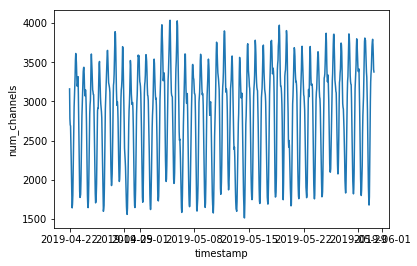

In [39]:
sns.lineplot(LoL['timestamp'],LoL['num_channels'])

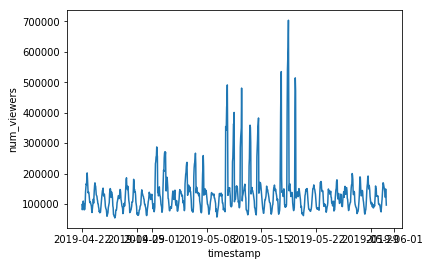

In [45]:
sns.lineplot(x='timestamp', y='num_viewers', data=LoL)

In [46]:
def train_lstm(train, feature_names, lags, look_back, predict_window):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y

    model = Sequential()
    model.add(LSTM(32, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='squared_hinge', optimizer='adam')
    model.fit(train_X, train_Y, epochs=300, batch_size=10, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [ ]:
timeseries_to_supervised()

In [94]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# run a repeated experiment
def experiment(repeats, series, features):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, features)
	supervised_values = supervised.values[features:,:]
	# split data into train and test-sets
	train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, 1, 500, 1)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores
 
# execute the experiment
def run():
	# load dataset
	series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
	# experiment
	repeats = 10
	results = DataFrame()
	# run experiment
	features = 1
	results['results'] = experiment(repeats, series, features)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment_features_1.csv', index=False)
 
 # entry point
# run()